In [10]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [11]:
# 1. Extract Dataset
# -------------------------------
zip_path = "/content/sample_data/dataset/archive (1).zip"
extract_path = "/content/sample_data/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Data extracted to:", extract_path)

Data extracted to: /content/sample_data/dataset


In [24]:
IMG_SIZE = 128  # or 256

def parse_image_mask(img_path, mask_path):
    # --- Image ---
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)       # RGB
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0            # normalize

    # --- Mask ---
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)      # grayscale
    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE), method="nearest")
    mask = tf.cast(mask > 127, tf.float32)            # binary (0/1)

    return img, mask


In [25]:
def create_dataset(img_dir, mask_dir, batch_size=8):
    img_files = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir)])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

    dataset = tf.data.Dataset.from_tensor_slices((img_files, mask_files))
    dataset = dataset.map(parse_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [31]:
import os

print("Root contents:", os.listdir(extract_path))
print("VOC contents:", os.listdir(os.path.join(extract_path, "voc_2012_segmentation_data")))


Root contents: ['voc_2012_segmentation_data', 'archive (1).zip']
VOC contents: ['train_labels', 'valid_labels', 'valid_images', 'train_images']


In [32]:
img_dir = os.path.join(extract_path, "voc_2012_segmentation_data/train_images")
mask_dir = os.path.join(extract_path, "voc_2012_segmentation_data/train_labels")

print("Image dir exists:", os.path.exists(img_dir))
print("Mask dir exists:", os.path.exists(mask_dir))
print("Num images:", len(os.listdir(img_dir)))
print("Num masks:", len(os.listdir(mask_dir)))


Image dir exists: True
Mask dir exists: True
Num images: 2217
Num masks: 1464


In [35]:
def get_matched_pairs(img_dir, mask_dir):
    img_files = sorted(os.listdir(img_dir))
    mask_files = sorted(os.listdir(mask_dir))

    # Remove extensions to compare
    img_basenames = [os.path.splitext(f)[0] for f in img_files]
    mask_basenames = [os.path.splitext(f)[0] for f in mask_files]

    # Keep only those that exist in both
    common = set(img_basenames).intersection(set(mask_basenames))

    img_paths = [os.path.join(img_dir, f"{name}.jpg") for name in common if f"{name}.jpg" in img_files]
    mask_paths = [os.path.join(mask_dir, f"{name}.png") for name in common if f"{name}.png" in mask_files]

    return img_paths, mask_paths


In [36]:
def create_dataset(img_dir, mask_dir, batch_size=8):
    img_files, mask_files = get_matched_pairs(img_dir, mask_dir)

    dataset = tf.data.Dataset.from_tensor_slices((img_files, mask_files))
    dataset = dataset.map(parse_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset



In [40]:
val_dataset = create_dataset(
    img_dir=os.path.join(extract_path, "voc_2012_segmentation_data/valid_images"),
    mask_dir=os.path.join(extract_path, "voc_2012_segmentation_data/valid_labels")
)

In [41]:
# 3. Metrics
# -------------------------------
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

In [42]:
# 4. Build U-Net
# -------------------------------
def build_unet(input_shape=(128, 128, 3)):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder
    c1 = tf.keras.layers.Conv2D(16, 3, activation="relu", padding="same")(inputs)
    c1 = tf.keras.layers.Conv2D(16, 3, activation="relu", padding="same")(c1)
    p1 = tf.keras.layers.MaxPooling2D()(c1)

    c2 = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(p1)
    c2 = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(c2)
    p2 = tf.keras.layers.MaxPooling2D()(c2)

    c3 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(p2)
    c3 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(c3)
    p3 = tf.keras.layers.MaxPooling2D()(c3)

    # Bottleneck
    b = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(p3)
    b = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(b)

    # Decoder
    u1 = tf.keras.layers.UpSampling2D()(b)
    u1 = tf.keras.layers.Concatenate()([u1, c3])
    c4 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(u1)
    c4 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(c4)

    u2 = tf.keras.layers.UpSampling2D()(c4)
    u2 = tf.keras.layers.Concatenate()([u2, c2])
    c5 = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(u2)
    c5 = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(c5)

    u3 = tf.keras.layers.UpSampling2D()(c5)
    u3 = tf.keras.layers.Concatenate()([u3, c1])
    c6 = tf.keras.layers.Conv2D(16, 3, activation="relu", padding="same")(u3)
    c6 = tf.keras.layers.Conv2D(16, 3, activation="relu", padding="same")(c6)

    outputs = tf.keras.layers.Conv2D(1, 1, activation="sigmoid")(c6)

    return tf.keras.Model(inputs, outputs)

model = build_unet()
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", iou_metric, dice_coef])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 128, 128,  │        448 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 128, 128,  │      2,320 │ conv2d_45[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 64,    │          0 │ conv2d_46[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_9[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 64, 64,    │      9,248 │ conv2d_47[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 32, 32,    │          0 │ conv2d_48[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_10… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_49[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 16, 16,    │          0 │ conv2d_50[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_11… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 16, 16,    │    147,584 │ conv2d_51[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_9     │ (None, 32, 32,    │          0 │ conv2d_52[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 32, 32,    │          0 │ up_sampling2d_9[… │
│ (Concatenate)       │ 192)              │            │ conv2d_50[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 32, 32,    │    110,656 │ concatenate_9[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_53[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_10    │ (None, 64, 64,    │          0 │ conv2d_54[0][0] 

 Total params: 487,297 (1.86 MB)

 Trainable params: 487,297 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


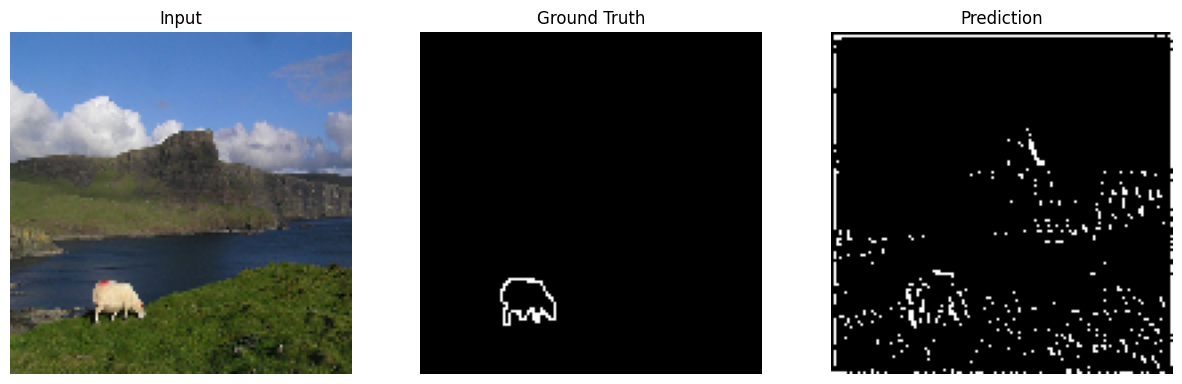

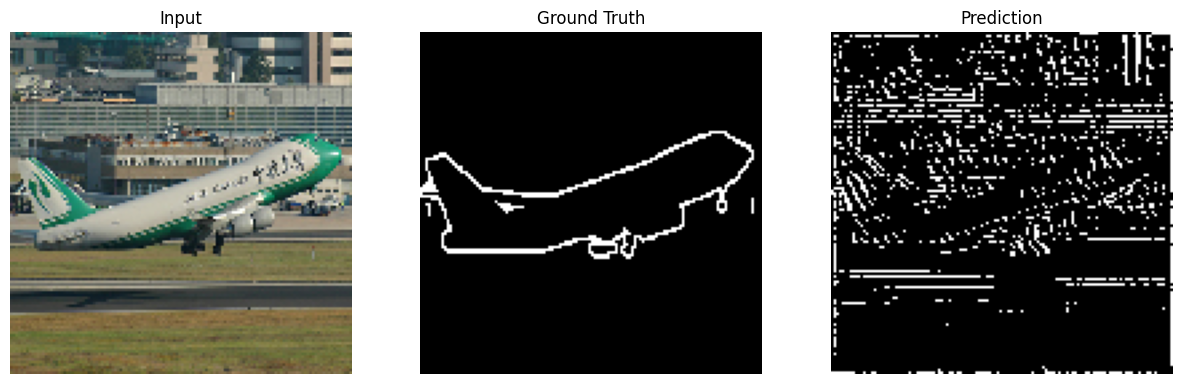

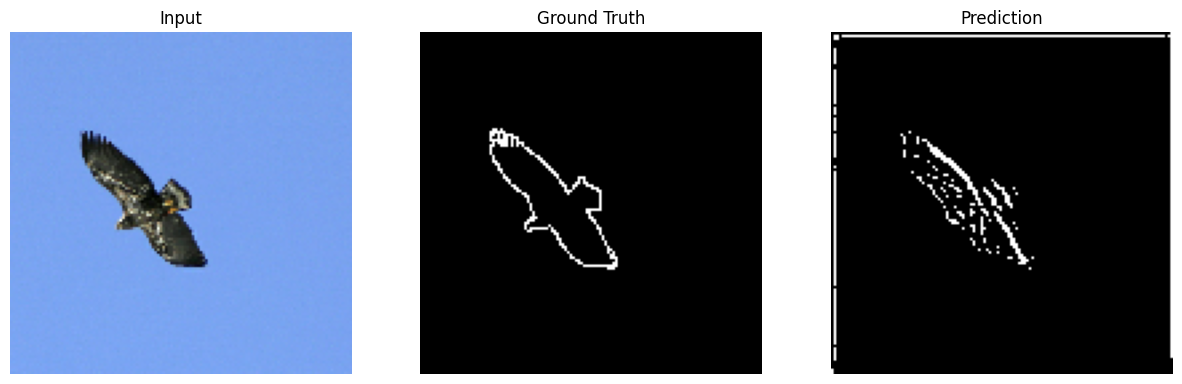

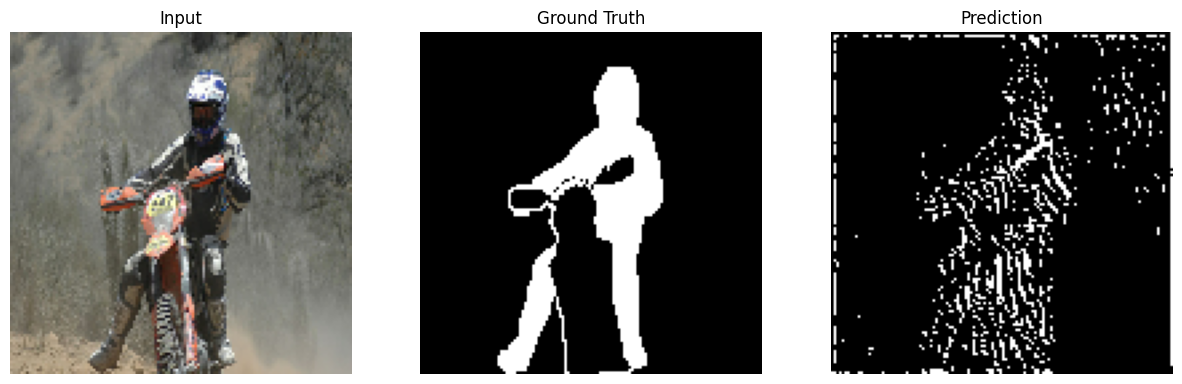

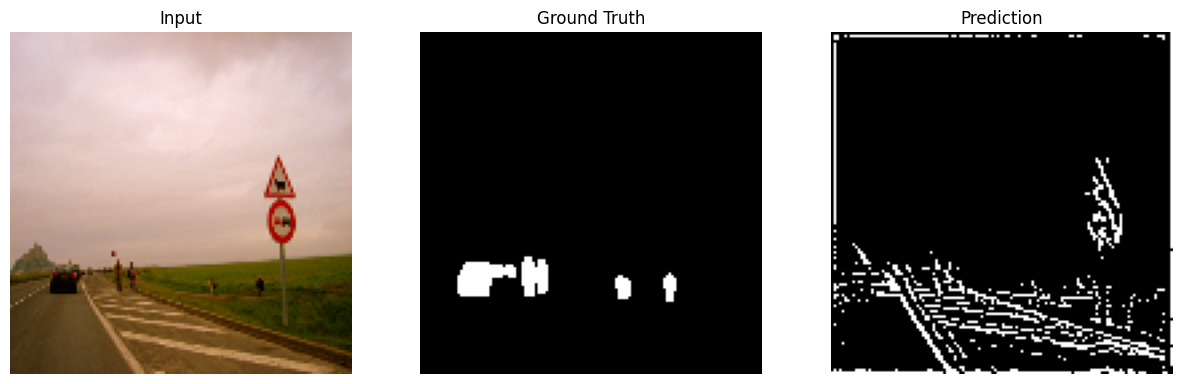

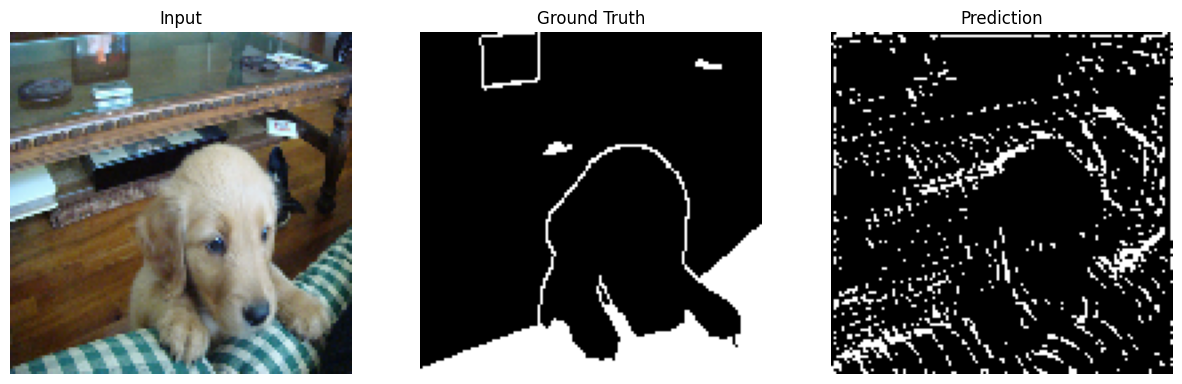

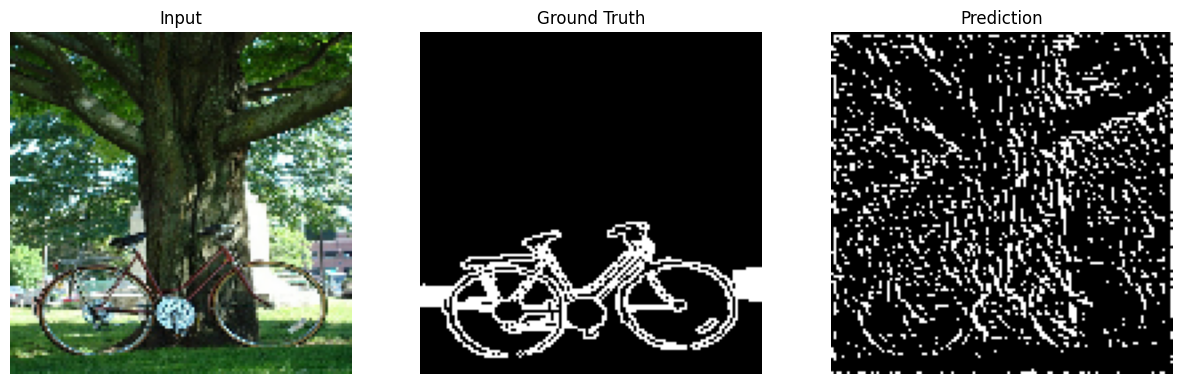

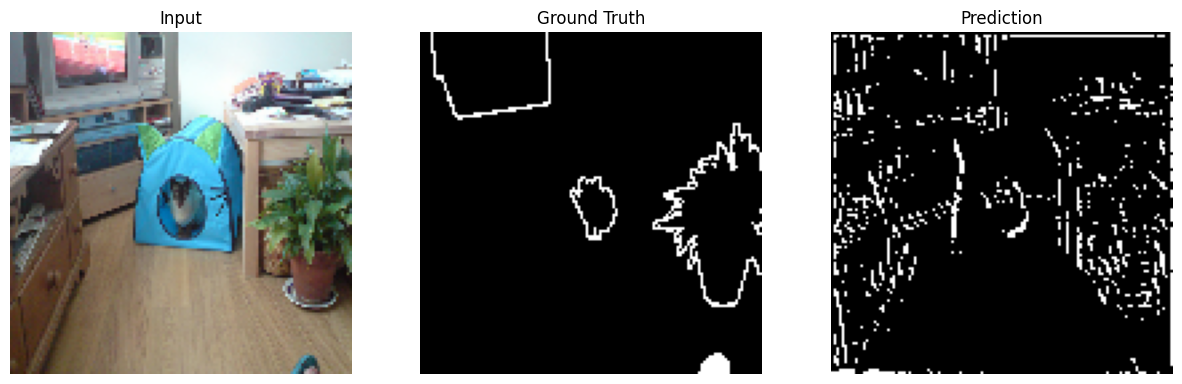

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


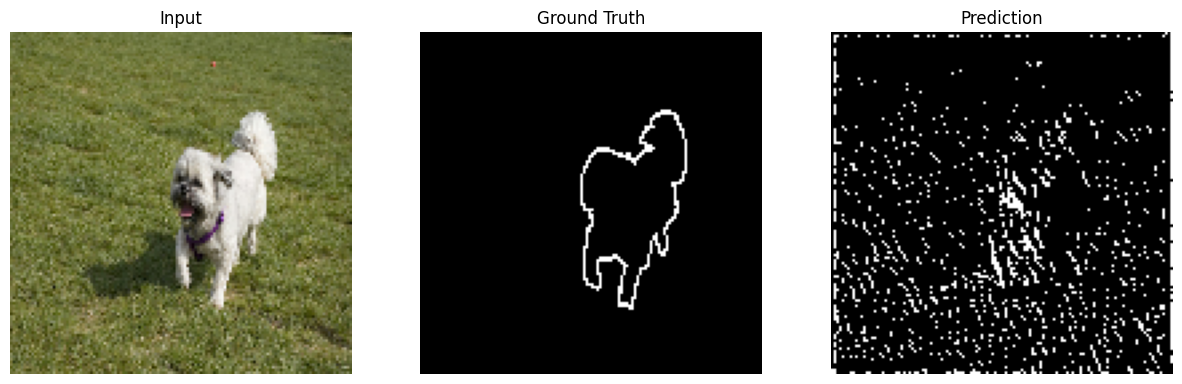

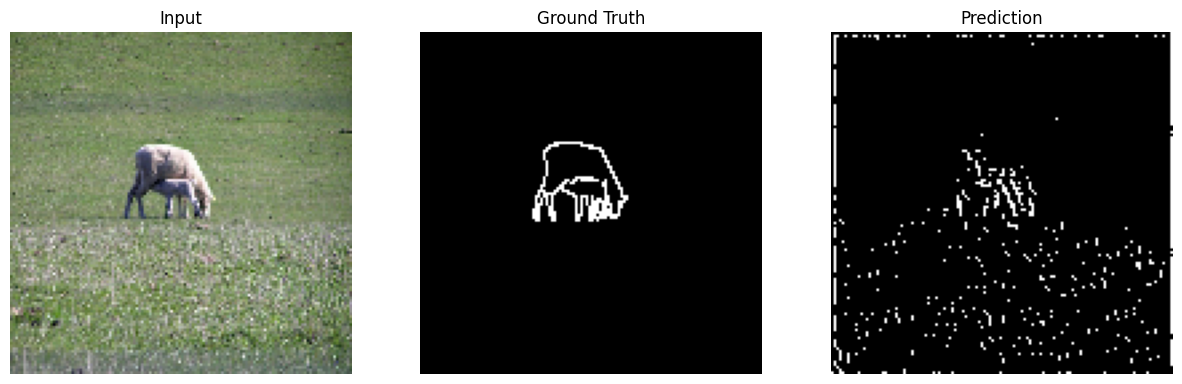

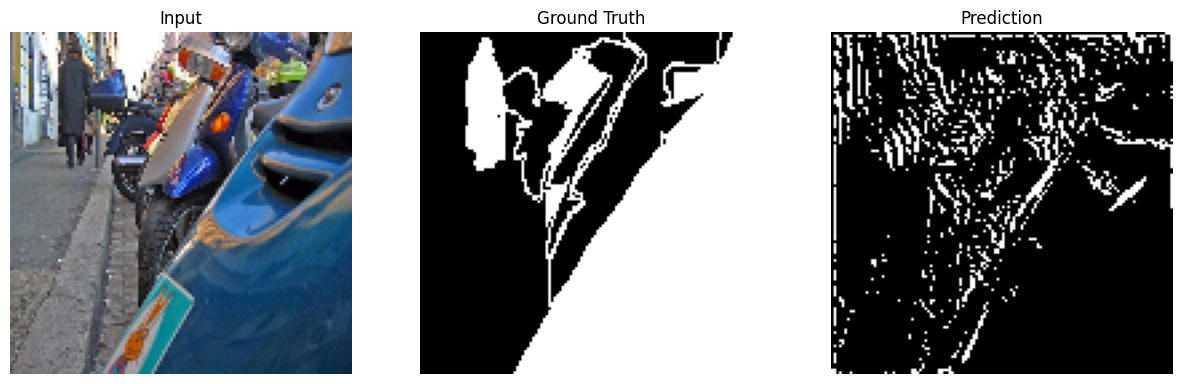

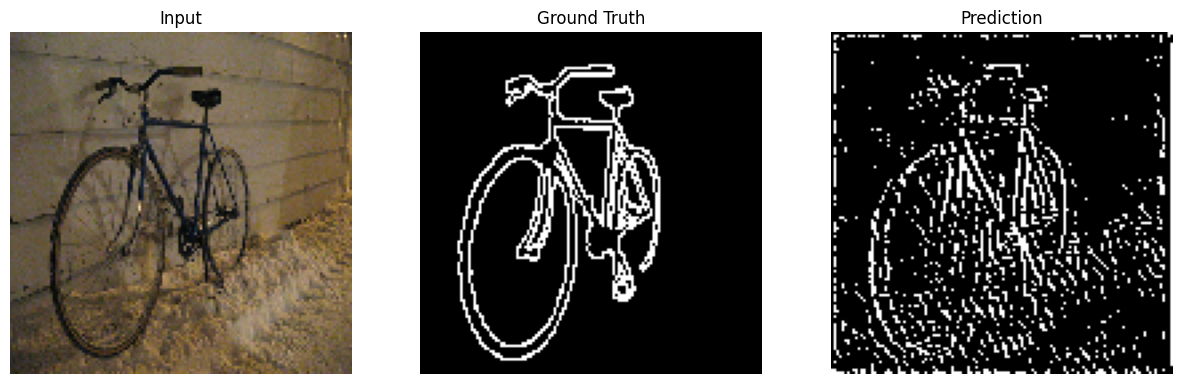

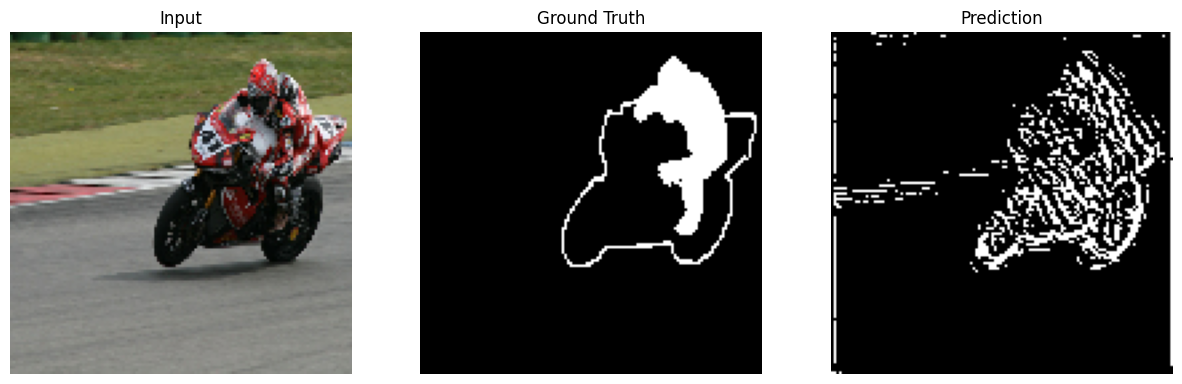

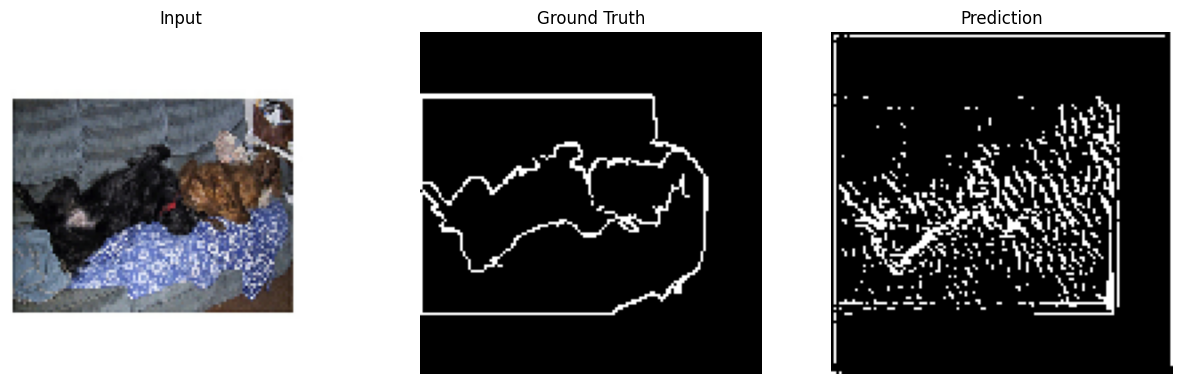

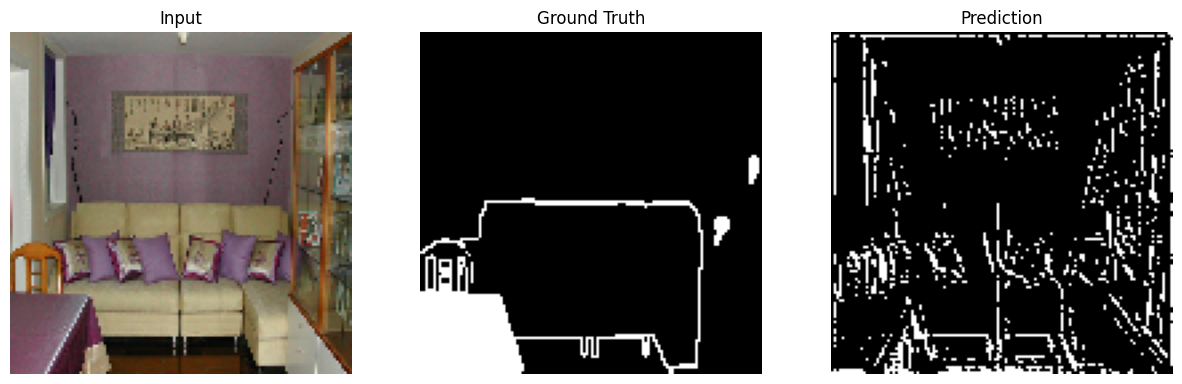

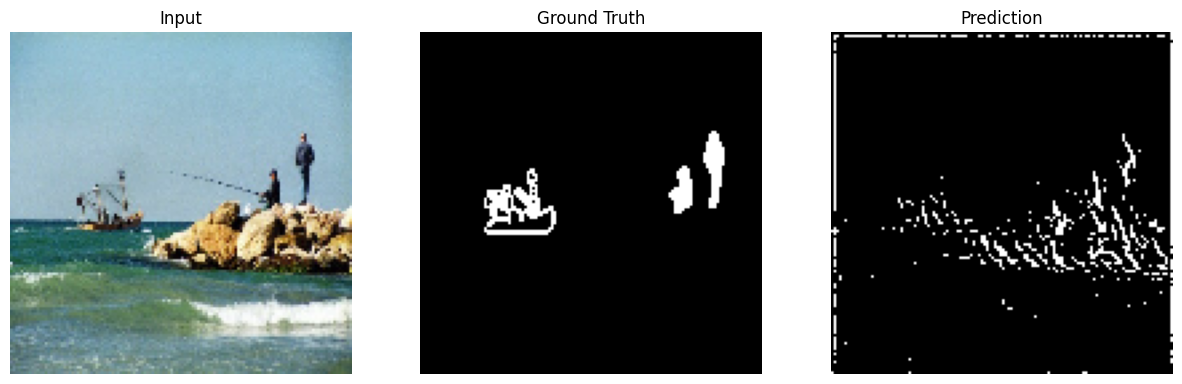

In [43]:
# 6. Visualize Predictions
# -------------------------------
def display(display_list, titles=["Input", "Ground Truth", "Prediction"]):
    plt.figure(figsize=(15, 5))
    for i, (img, title) in enumerate(zip(display_list, titles)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title)
        if img.shape[-1] == 3:
            plt.imshow(tf.keras.utils.array_to_img(img))
        else:
            plt.imshow(tf.squeeze(img), cmap="gray")
        plt.axis("off")
    plt.show()

def show_predictions(dataset, num=1):
    for images, masks in dataset.take(num):
        preds = model.predict(images)
        preds = (preds > 0.5).astype(np.uint8)
        for i in range(len(images)):
            display([images[i], masks[i], preds[i]])

# Show some early predictions
show_predictions(val_dataset, num=2)

In [45]:
train_dataset = create_dataset(
    img_dir=os.path.join(extract_path, "voc_2012_segmentation_data/train_images"),
    mask_dir=os.path.join(extract_path, "voc_2012_segmentation_data/train_labels")
)

val_dataset = create_dataset(
    img_dir=os.path.join(extract_path, "voc_2012_segmentation_data/valid_images"),
    mask_dir=os.path.join(extract_path, "voc_2012_segmentation_data/valid_labels")
)


In [46]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)


Epoch 1/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - accuracy: 0.8550 - dice_coef: 0.0066 - iou_metric: 0.0036 - loss: 0.4639 - val_accuracy: 0.8538 - val_dice_coef: 1.9528e-10 - val_iou_metric: 1.9528e-10 - val_loss: 0.4007
Epoch 2/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.8575 - dice_coef: 6.6344e-11 - iou_metric: 6.6344e-11 - loss: 0.3955 - val_accuracy: 0.8538 - val_dice_coef: 1.9528e-10 - val_iou_metric: 1.9528e-10 - val_loss: 0.3873
Epoch 3/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step - accuracy: 0.8575 - dice_coef: 6.6344e-11 - iou_metric: 6.6344e-11 - loss: 0.3825 - val_accuracy: 0.8538 - val_dice_coef: 1.9528e-10 - val_iou_metric: 1.9528e-10 - val_loss: 0.3940
Epoch 4/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 387s 2s/step - accuracy: 0.8575 - dice_coef: 6.6344e-11 - iou_metric: 6.6344e-11 - loss: 0.3804 - val_accuracy: 0.8538 - val_dice_coef: 1.9528e-10 - val_iou_metric: 1.9528e-10 - val_loss: 0.3949
Epoch 5/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.8575 -